# CAB420: Cumulative Match Characteristic Curve Example
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This simple example will demonstrate using a CMC curve to evalute matching performance. This is useful for a situation where we are performing a retrieval problem. 

In such a situation, we can consider our data as follows:
* We have a bunch of examples, for which we've extracted some sort of representation. This representation might be an embedding from a deep network, or a feature vector obtained from PCA or LDA (or both). For each of these samples, know the ID of each sample. We'll call this the **gallery**.
* We have another bunch of samples that we wish to match. For these we have the same type of features, and we need to compare these to the gallery images. We'll refer to these these samples as **probes**. In a live situation, we will not have IDs for these, however in an evaluation setting we may have samples.

Note these two sets of data are not necessarily the same data that is used to train the underlying PCA, LDA or deep network.

Given these two sets of data, we match each **probe** to the **gallery** in turn. To do this we
* Compare the current probe to all gallery samples, obtaining the distance between them. A smaller distance means they are more similar.
* Rank the gallery samples in order of similarity. The closest gallery sample is the sample that best matches the probe. The second closest probe sample is the second best match, and so on.
* If we are evaluatin matching performance (i.e. have IDs for the probe samples), find the rank of the true match. Ideally, this will be 1 (i.e. the best match is the correct one).

Once we have these matches, we can plot a cumulative match characteristic curve. This will show how ofter a rank of $n$ of better is achieved. 

This example will illustrate this process on very similar simulated data.

In [1]:
import numpy
import matplotlib.pyplot as plt

## Simple Data

We will start be creating some data. For each identify, we will have 1 feature, i.e. a single number. That number will be the ID istself, plus some noise, which will come from the numpy random number generator.

In [2]:
num_ids = 10

ID_1 = numpy.arange(0, num_ids, 1)
ID_2 = numpy.arange(0, num_ids, 1)
Feat_1 = ID_1 + (numpy.random.rand(num_ids) - 0.5)*4.0
Feat_2 = ID_2 + (numpy.random.rand(num_ids) - 0.5)*8.0
print(Feat_1)
print(Feat_2)

[1.41168699 2.25933536 2.66749024 1.98602832 3.53089272 5.11554551
 7.25372434 8.52044495 8.58511706 9.87025873]
[2.66124329 3.49365044 0.43377361 1.59978785 0.65809551 7.28412068
 4.16967264 6.84382489 6.84930216 8.18083178]


Our IDs start at 0, and the features are the ID plus some noise. With this is mind, consider the first entry in each of the feature arrays, `Feat_1` and `Feat_2`. Ideally, these should be `0`, but have been corrupted by noise. The ID in `Feat_1` that is closest to `Feat_2[0]` will be the gallery ID that best matches the probe, but this may not be the true match.

## Matching and Ranking

We will now compare each probe to the entire gallery. This will involve:
* Get the distance between our current probe and all samples in the gallery. Here, we'll use L1 distance (which given we have 1 dimension is the same as the L2 distance)
* Sort the distances
* Find the index of the correct match

We'll store a histogram of the correct match ranks.

In [3]:
# storage for ranked histogram
ranked_histogram = numpy.zeros(num_ids)

# loop over all IDs in the probe set
for i in range(len(ID_2)):
    # get the true ID of this sample
    true_ID = ID_2[i]
    print('Searching for ID %d' % (true_ID))

    # get the distance between the current probe and the whole gallery, L1 distance here. Note that L1
    # may not always be the best choice, so consider your distance metric given your problem
    dist = numpy.abs(Feat_2[i] - Feat_1)
    print('Distance between source feature and all target features:')
    print(dist)

    # get the sorted order of the distances
    a = numpy.argsort(dist)
    # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
    # ID is the second closest, and so on
    ranked = ID_1[a]
    print('Ranked IDs for query:')
    print(a)

    # find the location of the True Match in the ranked list
    ranked_result = numpy.where(ranked == true_ID)[0][0]
    print(ranked_result)

    # store the ranking result in the histogram
    ranked_histogram[ranked_result] += 1
    print('')
    
print(ranked_histogram)

Searching for ID 0
Distance between source feature and all target features:
[1.24955629e+00 4.01907926e-01 6.24695220e-03 6.75214967e-01
 8.69649435e-01 2.45430222e+00 4.59248105e+00 5.85920166e+00
 5.92387377e+00 7.20901544e+00]
Ranked IDs for query:
[2 1 3 4 0 5 6 7 8 9]
4

Searching for ID 1
Distance between source feature and all target features:
[2.08196345 1.23431508 0.8261602  1.50762212 0.03724228 1.62189507
 3.7600739  5.02679451 5.09146662 6.37660829]
Ranked IDs for query:
[4 2 1 3 5 0 6 7 8 9]
2

Searching for ID 2
Distance between source feature and all target features:
[0.97791338 1.82556175 2.23371663 1.55225471 3.09711911 4.6817719
 6.81995073 8.08667134 8.15134345 9.43648512]
Ranked IDs for query:
[0 3 1 2 4 5 6 7 8 9]
3

Searching for ID 3
Distance between source feature and all target features:
[0.18810086 0.65954751 1.06770239 0.38624047 1.93110487 3.51575766
 5.65393649 6.92065709 6.9853292  8.27047087]
Ranked IDs for query:
[0 3 1 2 4 5 6 7 8 9]
1

Searching for ID

## CMC Curve

Our ranked histogram is not quite the end result. This tells us how many times the true match was the closest sample, how many times it was second closest, and so on.

It's more useful to know how many times the true match was one of the top two matches, or top five matches. We refer to this as Rank-N. For example, Rank-5 means that the correct match was within the top five returned results.

The CMC can be obtained by performing a cumulative sum on the histogram we calculated above, such that:

$CMC_{N} = \sum_{i=1}^{N} r(i)$

where:
* $N$ is the rank we wish to calculate
* $r$ is our ranked histogram from the previous step

In [4]:
cmc = numpy.zeros(num_ids)
for i in range(num_ids):
    cmc[i] = numpy.sum(ranked_histogram[:(i + 1)])
    
print(cmc)

[ 0.  2.  3.  7.  9.  9. 10. 10. 10. 10.]


Text(0.5, 1.0, 'CMC Curve')

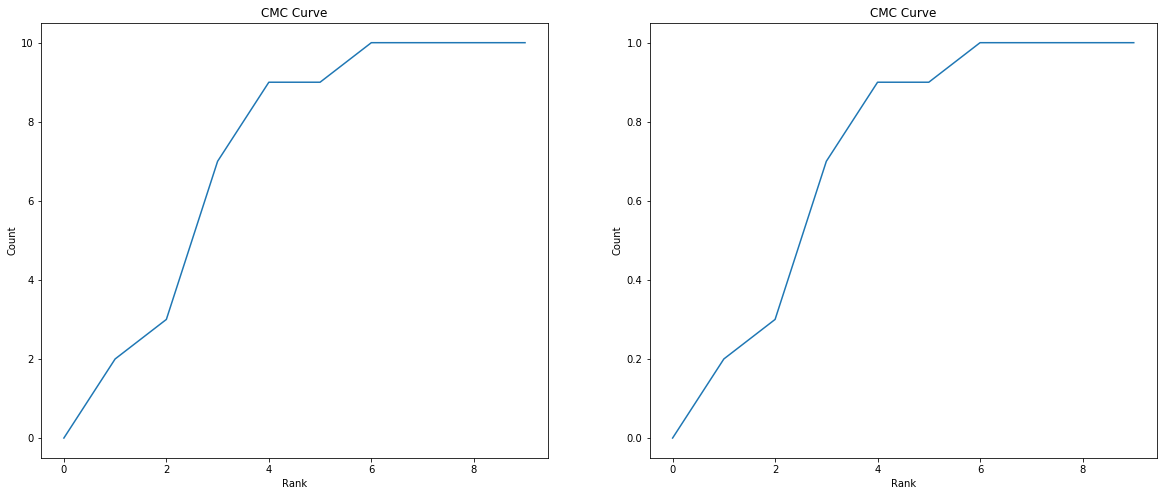

In [5]:
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 2, 1)
ax.plot(cmc)
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('CMC Curve')
ax = fig.add_subplot(1, 2, 2)
ax.plot(cmc/num_ids)
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('CMC Curve')

We typically plot CMC, and ideal performance is much like an ROC curve, where we want the curve to get as close to the top right corner possible (higher accuracy at lowest possible rank).

Often, we'll plot the curves as a percentage rather than raw counts, as shown on the right. This allows to report things like X% accuracy for Rank-5 retrieval.

## Things to Note

Keep in mind, this is a very simple example using 1D features, and is really just here to illustrate how to calculate rank accuracy and plot and CMC curve. It's highly unlikely for a start that you'll be using feature vectors with one value, but the general approach shown here will hold.